Exploration/Visualization of the data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from scipy.stats import linregress
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

Read in data and drop the useless column

In [21]:
year = 2021
final_df = pd.read_csv(f'data{year}.csv')
final_df = final_df.drop('Unnamed: 0', axis = 1)
final_df

,serial,sex,age,household_income,smartphone,race_label,state,year
0,2021HU0000025,Male,26,71200,True,Korean,CA,2021
1,2021HU0000025,Female,67,71200,True,White,CA,2021
2,2021HU0000025,Male,70,71200,True,Korean,CA,2021
3,2021HU0000037,Female,77,12000,True,Asian Indian,CA,2021
4,2021HU0000050,Male,83,61700,False,White,CA,2021
...,...,...,...,...,...,...,...,...
262665,2021HU0919711,Female,68,114000,False,White,CA,2021
262666,2021HU0919738,Female,38,155000,True,White,CA,2021
262667,2021HU0919738,Male,38,155000,True,White,CA,2021
262668,2021HU0919750,Female,43,100000,True,White,CA,2021


Plot household income to check for extreme outliers

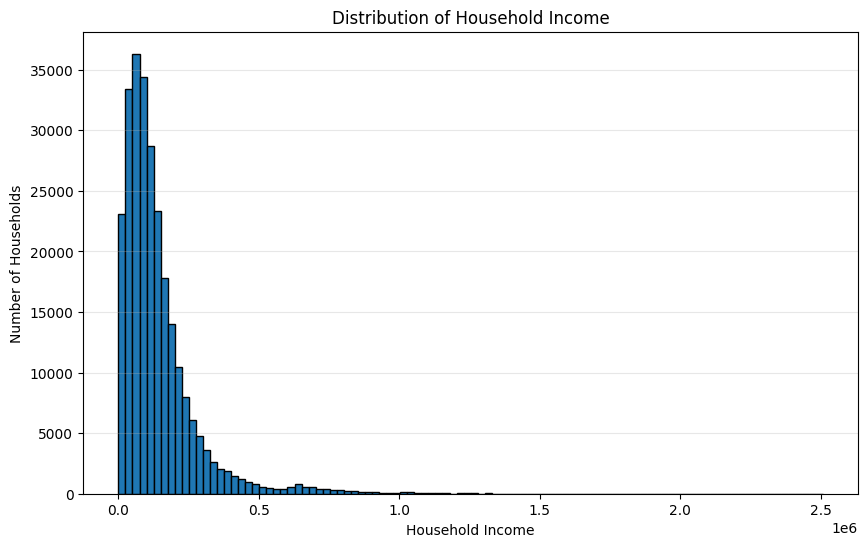

In [22]:
plt.figure(figsize=(10,6))
plt.hist(final_df["household_income"], bins=100, edgecolor='black')
plt.title("Distribution of Household Income")
plt.xlabel("Household Income")
plt.ylabel("Number of Households")
plt.grid(axis='y', alpha=0.3)
plt.show()

Trim the data to remove anything over $500,000, plot it and add a log normal distribution

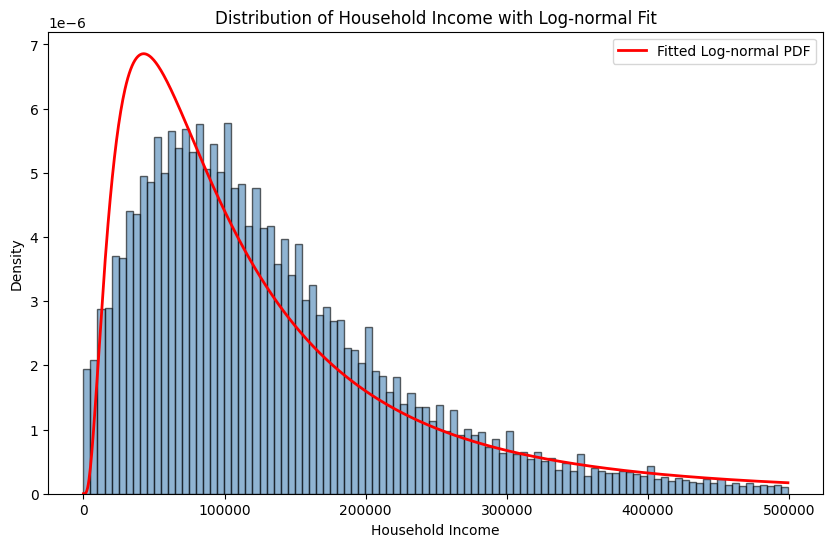

In [23]:
trimmed_df = final_df[(final_df['household_income'] < 500000) & (final_df['age'] <= 65) & (final_df['age'] > 18) & (final_df['race_label'] != 'Chinese')]


income = trimmed_df["household_income"]
income = income[income > 0]
shape, loc, scale = lognorm.fit(income, floc=0)
x = np.linspace(income.min(), income.max(), 1000)
pdf = lognorm.pdf(x, shape, loc, scale)
plt.figure(figsize=(10,6))
plt.hist(income, bins=100, density=True, alpha=0.6, color='steelblue', edgecolor='black')
plt.plot(x, pdf, 'r-', linewidth=2, label='Fitted Log-normal PDF')

plt.title("Distribution of Household Income with Log-normal Fit")
plt.xlabel("Household Income")
plt.ylabel("Density")
plt.legend()
plt.show()

Check values of races and remove any that are too small.

In [24]:
trimmed_df['race_label'].value_counts()

race_label
White                               75787
Asian Indian                        34472
Japanese                            33862
Korean                              32136
Black or African American            8266
American Indian or Alaska Native     2736
Other Asian                           710
Filipino                              536
Name: count, dtype: int64

Quick check to make sure everything looks good

In [25]:
trimmed_df.info()
trimmed_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 188505 entries, 0 to 262669
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   serial            188505 non-null  object
 1   sex               188505 non-null  object
 2   age               188505 non-null  int64 
 3   household_income  188505 non-null  int64 
 4   smartphone        188505 non-null  bool  
 5   race_label        188505 non-null  object
 6   state             188505 non-null  object
 7   year              188505 non-null  int64 
dtypes: bool(1), int64(3), object(4)
memory usage: 11.7+ MB


,age,household_income,year
count,188505.000000,188505.000000,188505.0
mean,42.755062,131007.524278,2021.0
std,13.306480,93099.796227,0.0
min,19.000000,1.000000,2021.0
25%,31.000000,62920.000000,2021.0
50%,43.000000,109800.000000,2021.0
75%,55.000000,176220.000000,2021.0
max,65.000000,499200.000000,2021.0


Percentage of people that dont have a smartphone

In [26]:
trimmed_df["smartphone"].value_counts(normalize=True)

smartphone
True     0.965757
False    0.034243
Name: proportion, dtype: float64

Look the the high level info for people with smartphones vs those without

In [27]:
trimmed_df.groupby("smartphone")["household_income"].describe()

,count,mean,std,min,25%,50%,75%,max
smartphone,,,,,,,,
False,6455.0,82795.588536,73211.863247,4.0,31400.0,62600.0,111200.0,490700.0
True,182050.0,132716.988959,93271.330917,1.0,64800.0,111000.0,178300.0,499200.0


Create a boxplot to show this

<Figure size 700x500 with 0 Axes>

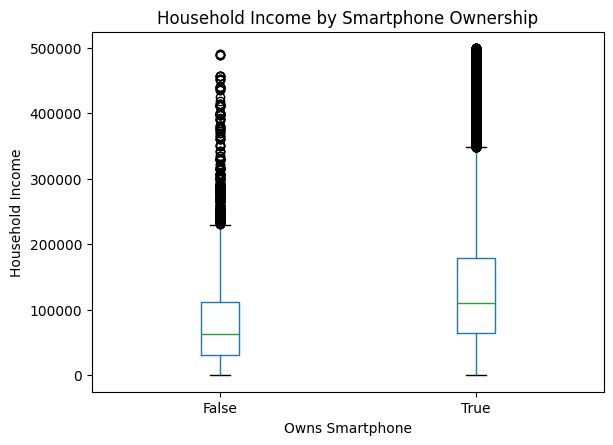

In [ ]:
plt.figure(figsize=(7,5))
trimmed_df.boxplot(column="household_income", by="smartphone", grid=False)
plt.title("Household Income by Smartphone Ownership")
plt.suptitle("")
plt.xlabel("Owns Smartphone")
plt.ylabel("Household Income")
plt.show()

Ownership by age (keep in mind I removed anyone 65+ so the 60+ box could be skewed)

C:\Users\lmikk\AppData\Local\Temp\ipykernel_5736\423238863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df["age_group"] = pd.cut(trimmed_df["age"], bins=bins, labels=labels, right=False)
C:\Users\lmikk\AppData\Local\Temp\ipykernel_5736\423238863.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ownership_by_age = trimmed_df.groupby("age_group")["smartphone"].mean()


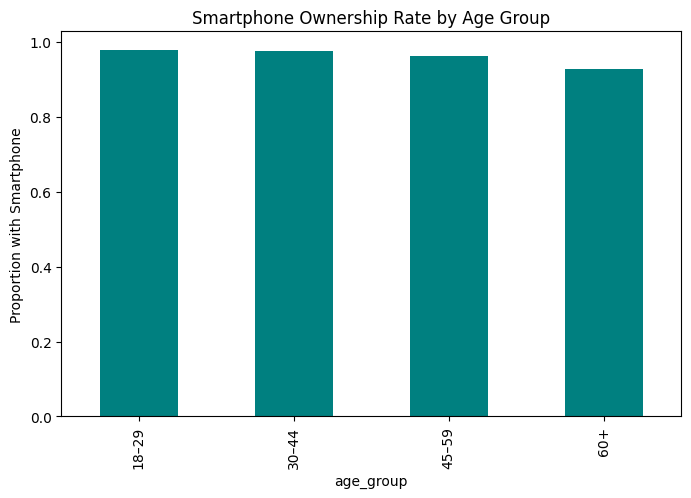

In [29]:
bins = [0, 30, 45, 60, 100]
labels = ["18–29", "30–44", "45–59", "60+"]
trimmed_df["age_group"] = pd.cut(trimmed_df["age"], bins=bins, labels=labels, right=False)

ownership_by_age = trimmed_df.groupby("age_group")["smartphone"].mean()
ownership_by_age.plot(kind="bar", figsize=(8,5), color='teal')
plt.title("Smartphone Ownership Rate by Age Group")
plt.ylabel("Proportion with Smartphone")
plt.show()


By race

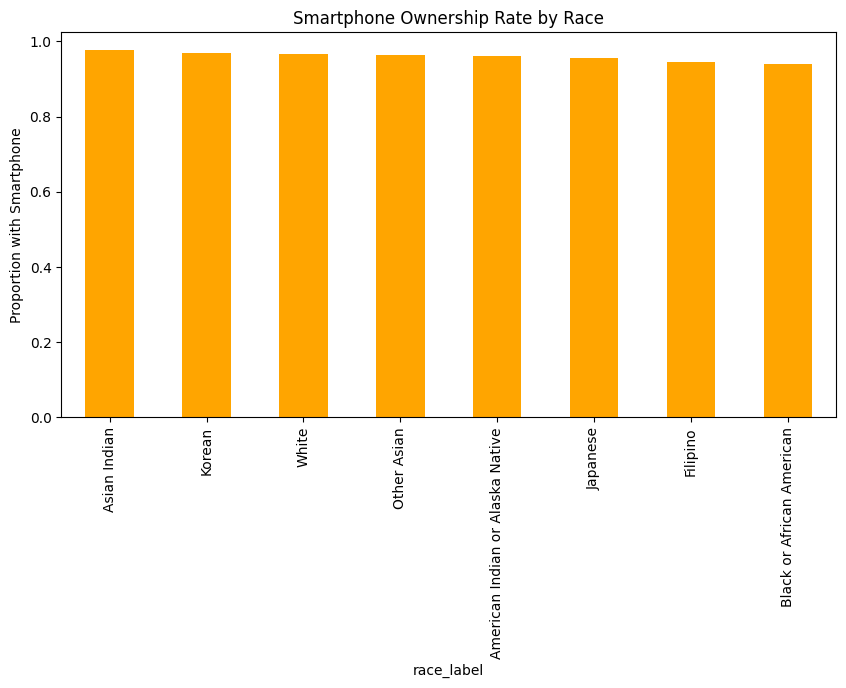

In [30]:
ownership_by_race = trimmed_df.groupby("race_label")["smartphone"].mean().sort_values(ascending=False)
ownership_by_race.plot(kind="bar", figsize=(10,5), color='orange')
plt.title("Smartphone Ownership Rate by Race")
plt.ylabel("Proportion with Smartphone")
plt.show()


Income group by phone ownership

C:\Users\lmikk\AppData\Local\Temp\ipykernel_5736\3491718203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df["income_band"] = pd.cut(
C:\Users\lmikk\AppData\Local\Temp\ipykernel_5736\3491718203.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ownership_by_income = trimmed_df.groupby("income_band")["smartphone"].mean()


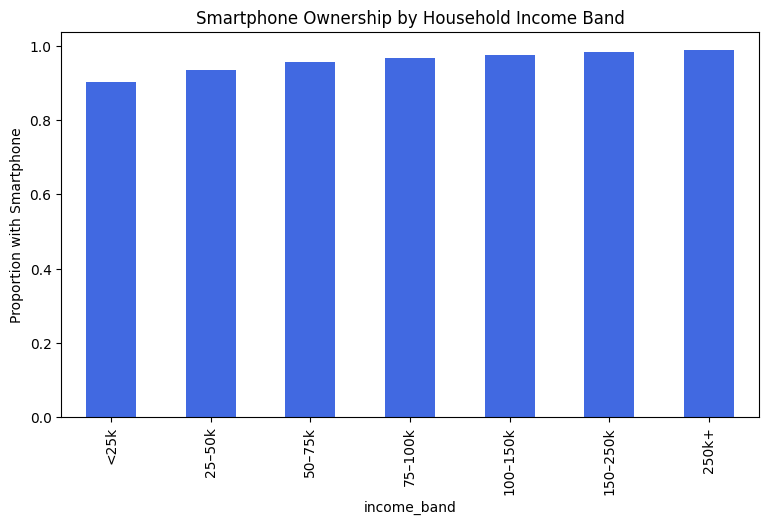

In [31]:
trimmed_df["income_band"] = pd.cut(
    trimmed_df["household_income"],
    bins=[0, 25000, 50000, 75000, 100000, 150000, 250000, 1000000],
    labels=["<25k", "25–50k", "50–75k", "75–100k", "100–150k", "150–250k", "250k+"]
)

ownership_by_income = trimmed_df.groupby("income_band")["smartphone"].mean()
ownership_by_income.plot(kind="bar", figsize=(9,5), color='royalblue')
plt.title("Smartphone Ownership by Household Income Band")
plt.ylabel("Proportion with Smartphone")
plt.show()


Phone ownership by race and income group

C:\Users\lmikk\AppData\Local\Temp\ipykernel_5736\1938218279.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trimmed_df.groupby(["income_band", "race_label"])["smartphone"].mean().unstack().plot(figsize=(12,6))


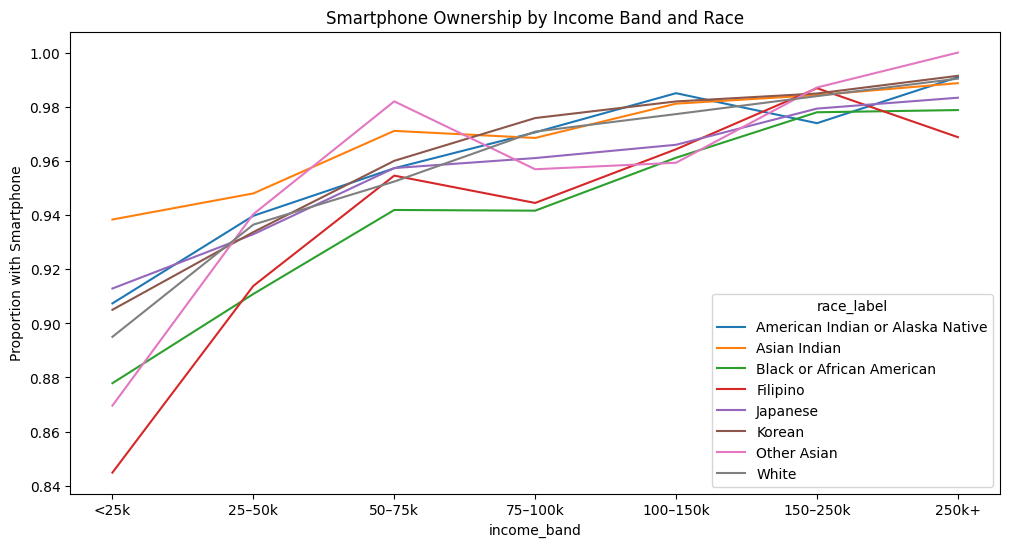

In [32]:
trimmed_df.groupby(["income_band", "race_label"])["smartphone"].mean().unstack().plot(figsize=(12,6))
plt.title("Smartphone Ownership by Income Band and Race")
plt.ylabel("Proportion with Smartphone")
plt.show()


Correlation between age, income and smartphone ownership

In [33]:
trimmed_df[["age", "household_income", "smartphone"]].corr(numeric_only=True)


,age,household_income,smartphone
age,1.000000,0.018468,-0.080801
household_income,0.018468,1.000000,0.097512
smartphone,-0.080801,0.097512,1.000000


Run cramers test to measure statistical strength of the correlation, range from 0-1 (1 is correlation and 0 is no correlation)

In [34]:
contingency = pd.crosstab(trimmed_df['race_label'], trimmed_df['smartphone'])
chi2, p, dof, expected = chi2_contingency(contingency)
cramers_v = np.sqrt(chi2 / (trimmed_df.shape[0] * (min(contingency.shape)-1)))
print("Cramer's V:", cramers_v)

Cramer's V: 0.04482178576331582


Linear Regression

In [35]:
print(trimmed_df.head())
print(trimmed_df.dtypes)


          serial     sex  age  household_income  smartphone  \
0  2021HU0000025    Male   26             71200        True   
6  2021HU0000089  Female   65            164000        True   
7  2021HU0000089    Male   28            164000        True   
8  2021HU0000089  Female   27            164000        True   
9  2021HU0000123  Female   40            102000        True   

                  race_label state  year age_group income_band  
0                     Korean    CA  2021     18–29      50–75k  
6                      White    CA  2021       60+    150–250k  
7  Black or African American    CA  2021     18–29    150–250k  
8                      White    CA  2021     18–29    150–250k  
9                      White    CA  2021     30–44    100–150k  
serial                object
sex                   object
age                    int64
household_income       int64
smartphone              bool
race_label            object
state                 object
year                   int64

Correlation coefficient between age and income: 0.02
Linear Regression Equation: income = 129.21 * age + 125483.07
R-squared: 0.00


c:\Users\lmikk\personalFiles\School\fall2025\stat386\data-acquisition-blog\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


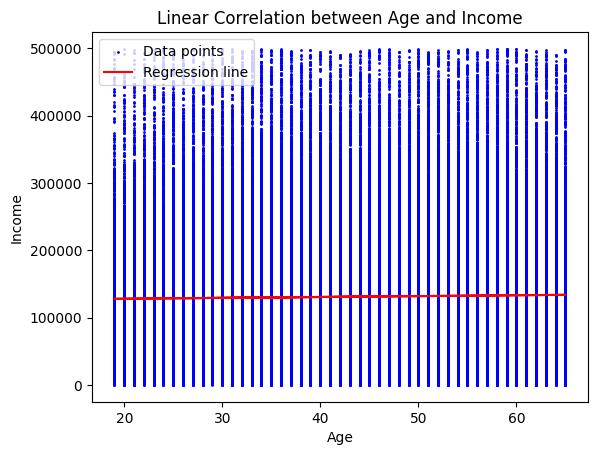

In [36]:
correlation = trimmed_df['age'].corr(trimmed_df['household_income'])
print(f"Correlation coefficient between age and income: {correlation:.2f}")

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(trimmed_df['age'], trimmed_df['household_income'])

print(f"Linear Regression Equation: income = {slope:.2f} * age + {intercept:.2f}")
print(f"R-squared: {r_value**2:.2f}")

# Plot data and regression line
plt.scatter(trimmed_df['age'], trimmed_df['household_income'], color='blue', label='Data points', s = 1)
plt.plot(trimmed_df['age'], intercept + slope * trimmed_df['age'], color='red', label='Regression line')
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Linear Correlation between Age and Income')
plt.legend()
plt.show()

Random forest

In [37]:
trimmed_df = trimmed_df.copy()

X = trimmed_df[['household_income']]
y = trimmed_df['age']

rf = RandomForestRegressor(n_estimators=100, random_state=37)
rf.fit(X, y)

leaf_indices = rf.apply(X)

kmeans = KMeans(n_clusters=5, random_state=37)
groups = kmeans.fit_predict(leaf_indices)

trimmed_df['group'] = groups

for g in sorted(trimmed_df['group'].unique()):
    subset = trimmed_df[trimmed_df['group'] == g]
    corr = subset['age'].corr(subset['household_income'])
    print(f"Group {g} correlation: {corr:.2f}")
    print(trimmed_df.groupby('group')[['age','household_income']].mean())



Group 0 correlation: 0.01
             age  household_income
group                             
0      42.320837     124043.062585
1      42.189572      75942.266488
2      43.656181     321474.724086
3      42.887237     191121.236976
4      43.276031      31245.434423
Group 1 correlation: 0.02
             age  household_income
group                             
0      42.320837     124043.062585
1      42.189572      75942.266488
2      43.656181     321474.724086
3      42.887237     191121.236976
4      43.276031      31245.434423
Group 2 correlation: 0.03
             age  household_income
group                             
0      42.320837     124043.062585
1      42.189572      75942.266488
2      43.656181     321474.724086
3      42.887237     191121.236976
4      43.276031      31245.434423
Group 3 correlation: 0.02
             age  household_income
group                             
0      42.320837     124043.062585
1      42.189572      75942.266488
2      43.656181     